# Q-GAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.03080568 -0.17569622  0.04693571  0.32065948] 0 1.0 False {}
state, action, reward, done, info
[0.02729176 0.01872698 0.0533489  0.04313988] 1 1.0 False {}
state, action, reward, done, info
[ 0.0276663   0.21304495  0.0542117  -0.23224525] 1 1.0 False {}
state, action, reward, done, info
[0.0319272  0.01719198 0.04956679 0.07703306] 0 1.0 False {}
state, action, reward, done, info
[ 0.03227103  0.2115696   0.05110745 -0.19960861] 1 1.0 False {}
state, action, reward, done, info
[ 0.03650243  0.40592475  0.04711528 -0.47574162] 1 1.0 False {}
state, action, reward, done, info
[ 0.04462092  0.60035084  0.03760045 -0.75321035] 1 1.0 False {}
state, action, reward, done, info
[ 0.05662794  0.79493474  0.02253624 -1.03382797] 1 1.0 False {}
state, action, reward, done, info
[ 0.07252663  0.98974985  0.00185968 -1.31935135] 1 1.0 False {}
state, action, reward, done, info
[ 0.09232163  1.18484824 -0.02452734 -1.61145168] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1848482441705297 -1.611451683175466


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [9]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [10]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, d_loss, g_loss, rewards_fake, rewards_real

In [11]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [12]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.d_loss, self.g_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, q_loss=self.q_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
train_episodes = 500          # max number of episodes to learn from
max_steps = 2000              # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
tf.reset_default_graph()

model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/Q-GAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 2.0 Average reward fake: 0.5078670382499695 Average reward real: 0.5027133226394653 Training q_loss: 0.3669 Training g_loss: 0.6775 Training d_loss: 1.3980 Explore P: 0.9998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 18.0 Average reward fake: 0.4983130991458893 Average reward real: 0.49818935990333557 Training q_loss: 0.3262 Training g_loss: 0.6965 Training d_loss: 1.3899 Explore P: 0.9980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 14.0 Average reward fake: 0.4942600131034851 Average reward real: 0.4961604177951813 Training q_loss: 0.3072 Training g_loss: 0.7047 Training d_loss: 1.3838 Explore P: 0.9966


-------------------------------------------------------------------------------
Episode: 23 Total reward: 27.0 Average reward fake: 0.3629417419433594 Average reward real: 0.5530793070793152 Training q_loss: 131904.7500 Training g_loss: 1.0135 Training d_loss: 1.0586 Explore P: 0.9499
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 26.0 Average reward fake: 0.34229061007499695 Average reward real: 0.6063584089279175 Training q_loss: 28689.7227 Training g_loss: 1.0721 Training d_loss: 0.9561 Explore P: 0.9475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 28.0 Average reward fake: 0.48271098732948303 Average reward real: 0.5494839549064636 Training q_loss: 3175.7212 Training g_loss: 0.7283 Training d_loss: 1.3159 E

-------------------------------------------------------------------------------
Episode: 47 Total reward: 24.0 Average reward fake: 0.14778004586696625 Average reward real: 0.9761108160018921 Training q_loss: 38128.8789 Training g_loss: 1.9120 Training d_loss: 0.2091 Explore P: 0.9031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 16.0 Average reward fake: 0.15500178933143616 Average reward real: 0.8321852684020996 Training q_loss: 35595.5703 Training g_loss: 1.8643 Training d_loss: 0.4397 Explore P: 0.9017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 49 Total reward: 33.0 Average reward fake: 0.3557310998439789 Average reward real: 0.7649489641189575 Training q_loss: 15798.8984 Training g_loss: 1.0336 Training d_loss: 0.8320 E

-------------------------------------------------------------------------------
Episode: 70 Total reward: 31.0 Average reward fake: 0.3834300637245178 Average reward real: 0.6230062246322632 Training q_loss: 27464.4102 Training g_loss: 0.9586 Training d_loss: 0.9758 Explore P: 0.8556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 16.0 Average reward fake: 0.3731430768966675 Average reward real: 0.5865784883499146 Training q_loss: 693.7927 Training g_loss: 0.9858 Training d_loss: 1.0204 Explore P: 0.8543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 16.0 Average reward fake: 0.42960745096206665 Average reward real: 0.5999983549118042 Training q_loss: 73973.4609 Training g_loss: 0.8449 Training d_loss: 1.1020 Expl

-------------------------------------------------------------------------------
Episode: 93 Total reward: 41.0 Average reward fake: 0.01747014746069908 Average reward real: 0.9911982417106628 Training q_loss: 1026.7144 Training g_loss: 4.0473 Training d_loss: 0.0320 Explore P: 0.8122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 16.0 Average reward fake: 0.25984901189804077 Average reward real: 0.8591593503952026 Training q_loss: 440.0839 Training g_loss: 1.3477 Training d_loss: 1.2948 Explore P: 0.8109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 20.0 Average reward fake: 0.6661967039108276 Average reward real: 0.4726029932498932 Training q_loss: 713.9810 Training g_loss: 0.4062 Training d_loss: 4.1648 Explor

-------------------------------------------------------------------------------
Episode: 116 Total reward: 34.0 Average reward fake: 0.34548431634902954 Average reward real: 0.6001858115196228 Training q_loss: 392.3038 Training g_loss: 1.0628 Training d_loss: 0.9605 Explore P: 0.7789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 17.0 Average reward fake: 0.35580095648765564 Average reward real: 0.5646370649337769 Training q_loss: 8302.0752 Training g_loss: 1.0334 Training d_loss: 1.0445 Explore P: 0.7776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 25.0 Average reward fake: 0.34212490916252136 Average reward real: 0.6762712597846985 Training q_loss: 485.2079 Training g_loss: 1.0726 Training d_loss: 0.8498 Ex

-------------------------------------------------------------------------------
Episode: 139 Total reward: 24.0 Average reward fake: 0.2566959261894226 Average reward real: 0.6681121587753296 Training q_loss: 2833.4265 Training g_loss: 1.3599 Training d_loss: 0.8197 Explore P: 0.7486
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 15.0 Average reward fake: 0.2686631381511688 Average reward real: 0.7684656381607056 Training q_loss: 4393.7681 Training g_loss: 1.3144 Training d_loss: 0.6439 Explore P: 0.7475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 13.0 Average reward fake: 0.26626884937286377 Average reward real: 0.7505618929862976 Training q_loss: 340.7486 Training g_loss: 1.3232 Training d_loss: 0.6891 Exp

-------------------------------------------------------------------------------
Episode: 162 Total reward: 22.0 Average reward fake: 0.513935923576355 Average reward real: 0.566510021686554 Training q_loss: 145.6298 Training g_loss: 0.7039 Training d_loss: 1.3473 Explore P: 0.7079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 21.0 Average reward fake: 0.3974544107913971 Average reward real: 0.5767471790313721 Training q_loss: 228.3210 Training g_loss: 0.9731 Training d_loss: 1.1620 Explore P: 0.7065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 78.0 Average reward fake: 0.440427303314209 Average reward real: 0.543951690196991 Training q_loss: 160.7273 Training g_loss: 0.8372 Training d_loss: 1.2605 Explore P:

-------------------------------------------------------------------------------
Episode: 185 Total reward: 38.0 Average reward fake: 0.4257565140724182 Average reward real: 0.779970645904541 Training q_loss: 215.1153 Training g_loss: 1.6044 Training d_loss: 1.0874 Explore P: 0.6593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 31.0 Average reward fake: 0.521178662776947 Average reward real: 0.4662257134914398 Training q_loss: 70.0294 Training g_loss: 0.6941 Training d_loss: 2.0595 Explore P: 0.6573
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 56.0 Average reward fake: 0.47884759306907654 Average reward real: 0.45760542154312134 Training q_loss: 169.5091 Training g_loss: 0.7370 Training d_loss: 1.4503 Explore

-------------------------------------------------------------------------------
Episode: 208 Total reward: 35.0 Average reward fake: 0.3549385368824005 Average reward real: 0.6157572269439697 Training q_loss: 45.2329 Training g_loss: 1.0429 Training d_loss: 0.9521 Explore P: 0.6123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 17.0 Average reward fake: 0.4343704581260681 Average reward real: 0.5566030144691467 Training q_loss: 117.9106 Training g_loss: 0.8514 Training d_loss: 1.1994 Explore P: 0.6113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 37.0 Average reward fake: 0.5089343190193176 Average reward real: 0.4684116244316101 Training q_loss: 103.6437 Training g_loss: 0.6771 Training d_loss: 1.5008 Explore

-------------------------------------------------------------------------------
Episode: 231 Total reward: 45.0 Average reward fake: 0.454693466424942 Average reward real: 0.5509737730026245 Training q_loss: 68.7600 Training g_loss: 0.7892 Training d_loss: 1.2113 Explore P: 0.5525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 23.0 Average reward fake: 0.4635400176048279 Average reward real: 0.5996429920196533 Training q_loss: 347.9431 Training g_loss: 0.7695 Training d_loss: 1.1446 Explore P: 0.5513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 29.0 Average reward fake: 0.44711318612098694 Average reward real: 0.5084996223449707 Training q_loss: 35.5844 Training g_loss: 0.8069 Training d_loss: 1.2821 Explore 

-------------------------------------------------------------------------------
Episode: 254 Total reward: 65.0 Average reward fake: 0.5532879829406738 Average reward real: 0.43915286660194397 Training q_loss: 26.5436 Training g_loss: 0.5935 Training d_loss: 1.6423 Explore P: 0.4986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 42.0 Average reward fake: 0.42469626665115356 Average reward real: 0.5430935621261597 Training q_loss: 55.5728 Training g_loss: 0.8564 Training d_loss: 1.1800 Explore P: 0.4966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 15.0 Average reward fake: 0.4597468972206116 Average reward real: 0.5847512483596802 Training q_loss: 19.9505 Training g_loss: 0.7773 Training d_loss: 1.1682 Explore

-------------------------------------------------------------------------------
Episode: 277 Total reward: 38.0 Average reward fake: 0.5134555101394653 Average reward real: 0.45492544770240784 Training q_loss: 20.1720 Training g_loss: 0.6712 Training d_loss: 1.5255 Explore P: 0.4395
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 88.0 Average reward fake: 0.47343263030052185 Average reward real: 0.516729474067688 Training q_loss: 251.9424 Training g_loss: 0.7484 Training d_loss: 1.3371 Explore P: 0.4357
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 74.0 Average reward fake: 0.5349095463752747 Average reward real: 0.429793119430542 Training q_loss: 8.4266 Training g_loss: 0.6430 Training d_loss: 1.7631 Explore P

-------------------------------------------------------------------------------
Episode: 300 Total reward: 103.0 Average reward fake: 0.4826907515525818 Average reward real: 0.48803600668907166 Training q_loss: 3.8965 Training g_loss: 0.7285 Training d_loss: 1.3802 Explore P: 0.3675
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 100.0 Average reward fake: 0.5128573179244995 Average reward real: 0.555367648601532 Training q_loss: 5.9084 Training g_loss: 0.6691 Training d_loss: 1.3238 Explore P: 0.3639
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 82.0 Average reward fake: 0.5863355398178101 Average reward real: 0.4564848840236664 Training q_loss: 5.0355 Training g_loss: 0.5335 Training d_loss: 1.7316 Explore P:

-------------------------------------------------------------------------------
Episode: 323 Total reward: 168.0 Average reward fake: 0.4107666015625 Average reward real: 0.4413925111293793 Training q_loss: 33.8722 Training g_loss: 0.8898 Training d_loss: 1.3578 Explore P: 0.2859
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 129.0 Average reward fake: 0.4688180387020111 Average reward real: 0.5539906024932861 Training q_loss: 13.1332 Training g_loss: 0.7583 Training d_loss: 1.2427 Explore P: 0.2824
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 130.0 Average reward fake: 0.5130596160888672 Average reward real: 0.4480055868625641 Training q_loss: 7.4025 Training g_loss: 0.6675 Training d_loss: 1.5294 Explore P:

-------------------------------------------------------------------------------
Episode: 346 Total reward: 199.0 Average reward fake: 0.5152565240859985 Average reward real: 0.4550270140171051 Training q_loss: 16.0357 Training g_loss: 0.6629 Training d_loss: 1.6291 Explore P: 0.1973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 197.0 Average reward fake: 0.5053097009658813 Average reward real: 0.35813838243484497 Training q_loss: 5.5751 Training g_loss: 0.6825 Training d_loss: 1.7817 Explore P: 0.1937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 199.0 Average reward fake: 0.4972427487373352 Average reward real: 0.4859388470649719 Training q_loss: 11.7222 Training g_loss: 0.6988 Training d_loss: 1.4279 Explor

-------------------------------------------------------------------------------
Episode: 369 Total reward: 199.0 Average reward fake: 0.45897284150123596 Average reward real: 0.48454245924949646 Training q_loss: 2.1689 Training g_loss: 0.7785 Training d_loss: 1.3473 Explore P: 0.1301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 199.0 Average reward fake: 0.5497236847877502 Average reward real: 0.4218747019767761 Training q_loss: 8.7079 Training g_loss: 0.6000 Training d_loss: 1.6888 Explore P: 0.1277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 198.0 Average reward fake: 0.5829719305038452 Average reward real: 0.506375253200531 Training q_loss: 10.1312 Training g_loss: 0.5396 Training d_loss: 1.5657 Explore

-------------------------------------------------------------------------------
Episode: 392 Total reward: 186.0 Average reward fake: 0.48710647225379944 Average reward real: 0.4727361798286438 Training q_loss: 4.4832 Training g_loss: 0.7202 Training d_loss: 1.4302 Explore P: 0.0867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 199.0 Average reward fake: 0.49240797758102417 Average reward real: 0.5317021608352661 Training q_loss: 3.2798 Training g_loss: 0.7101 Training d_loss: 1.3129 Explore P: 0.0852
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 199.0 Average reward fake: 0.46599406003952026 Average reward real: 0.4922753870487213 Training q_loss: 3.5667 Training g_loss: 0.7655 Training d_loss: 1.3480 Explor

-------------------------------------------------------------------------------
Episode: 415 Total reward: 199.0 Average reward fake: 0.4807755947113037 Average reward real: 0.5126012563705444 Training q_loss: 10.9899 Training g_loss: 0.7323 Training d_loss: 1.3258 Explore P: 0.0587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 182.0 Average reward fake: 0.5422846078872681 Average reward real: 0.49528342485427856 Training q_loss: 10.7757 Training g_loss: 0.6128 Training d_loss: 1.4978 Explore P: 0.0579
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 199.0 Average reward fake: 0.5593996047973633 Average reward real: 0.47619685530662537 Training q_loss: 5.9822 Training g_loss: 0.5809 Training d_loss: 1.5879 Explo

-------------------------------------------------------------------------------
Episode: 438 Total reward: 199.0 Average reward fake: 0.4806118607521057 Average reward real: 0.46774086356163025 Training q_loss: 15.8470 Training g_loss: 0.7327 Training d_loss: 1.4206 Explore P: 0.0410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 199.0 Average reward fake: 0.5136063694953918 Average reward real: 0.4783174991607666 Training q_loss: 3.1087 Training g_loss: 0.6671 Training d_loss: 1.4616 Explore P: 0.0404
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 199.0 Average reward fake: 0.5164450407028198 Average reward real: 0.49645814299583435 Training q_loss: 3.8479 Training g_loss: 0.6603 Training d_loss: 1.4318 Explor

-------------------------------------------------------------------------------
Episode: 461 Total reward: 131.0 Average reward fake: 0.5207211971282959 Average reward real: 0.511159360408783 Training q_loss: 5.0885 Training g_loss: 0.6535 Training d_loss: 1.4492 Explore P: 0.0302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 199.0 Average reward fake: 0.531214714050293 Average reward real: 0.47218209505081177 Training q_loss: 1.9787 Training g_loss: 0.6328 Training d_loss: 1.5325 Explore P: 0.0298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 199.0 Average reward fake: 0.49267810583114624 Average reward real: 0.5574042201042175 Training q_loss: 3.5401 Training g_loss: 0.7081 Training d_loss: 1.2736 Explore P

-------------------------------------------------------------------------------
Episode: 484 Total reward: 199.0 Average reward fake: 0.5323575139045715 Average reward real: 0.45588675141334534 Training q_loss: 12.1981 Training g_loss: 0.6305 Training d_loss: 1.5559 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 120.0 Average reward fake: 0.5439224243164062 Average reward real: 0.511393129825592 Training q_loss: 3.7832 Training g_loss: 0.6089 Training d_loss: 1.4601 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 199.0 Average reward fake: 0.5115857124328613 Average reward real: 0.516166627407074 Training q_loss: 0.9878 Training g_loss: 0.6703 Training d_loss: 1.3793 Explore P

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

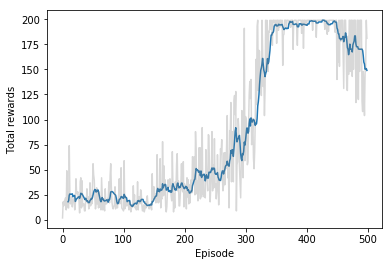

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

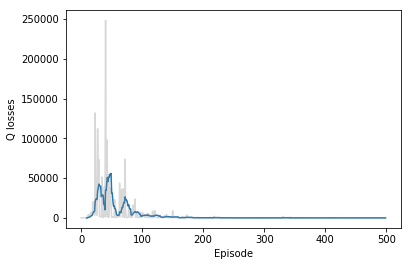

In [20]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

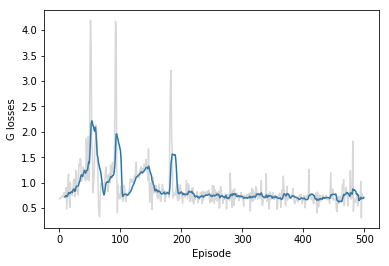

In [21]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

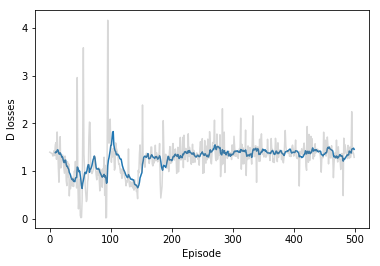

In [22]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
test_episodes = 5
test_max_steps = 200
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            #env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/Q-GAN-cartpole.ckpt


## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.